# **MixupVI**

#### Standard imports

In [1]:
import scanpy as sc
import scvi
import anndata as ad
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from loguru import logger

from constants import (
    BENCHMARK_DATASET,
    SIGNATURE_CHOICE,
    N_SAMPLES,
    GENERATIVE_MODELS,
    BASELINES,
    CAT_COV,
    CONT_COV,
    ENCODE_COVARIATES,
)
import scvi
sc.set_figure_params(figsize=(4, 4))

from benchmark_utils import (
    add_cell_types_grouped,
    create_dirichlet_pseudobulk_dataset,
    run_sanity_check,
    create_signature,
    perform_nnls,
    create_latent_signature,
    perform_latent_deconv,
    fit_mixupvi,
)

# for white background of figures (only for docs rendering)
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

/home/owkin/deepdeconv-fork/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/home/owkin/deepdeconv-fork/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
/home/owkin/.conda/envs/scvi/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-03-01 14:44:35,696	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-03-01 14:44:36,232	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ip

## 1. Data preparation and model training

### 1.1 Loading and preparing data 

#### Cross-tissue immune cell analysis reveals tissue-specific features in humans - Global

Despite their crucial role in health and disease, our knowledge of immune cells within human tissues remains limited. We surveyed the immune compartment of 16 tissues from 12 adult donors by single-cell RNA sequencing and VDJ sequencing generating a dataset of ~360,000 cells. To systematically resolve immune cell heterogeneity across tissues, we developed CellTypist, a machine learning tool for rapid and precise cell type annotation. Using this approach, combined with detailed curation, we determined the tissue distribution of finely phenotyped immune cell types, revealing hitherto unappreciated tissue-specific features and clonal architecture of T and B cells. Our multitissue approach lays the foundation for identifying highly resolved immune cell types by leveraging a common reference dataset, tissue-integrated expression analysis, and antigen receptor sequencing.

```{important}
All scvi-tools models require AnnData objects as input.
```

In [2]:
adata = sc.read("/home/owkin/data/cti_data/processed/cti_processed_3000.h5ad")

In [3]:
# %% add cell types groups and split train/test
adata, train_test_index = add_cell_types_grouped(adata,
                               "3rd_level_granularity"
                               )
# first dataset
adata_train = adata[train_test_index["Train index"]]
adata_test = adata[train_test_index["Test index"]]

print(adata_train.obs["cell_types_grouped"].value_counts())

adata_train = adata_train.copy()
adata_test = adata_test.copy()

cell_types_grouped
Naive_CD4T    26453
Mem_CD8T      26402
Mem_CD4T      17984
NK            14747
MemB          14457
Mono          12133
Macro         11088
NaiveB         6999
Tregs          6071
gdT            5789
Plasma         3990
Naive_CD8T     3901
Mast           1646
DC              883
pDC             356
ImmatureB        57
Name: count, dtype: int64


#### Train Model(s)

##### 1 - First, train a MixupVI model, with no batch effects correction

In [11]:
model_path_1 = "models/mixupvi_nobatch"

model_1 = fit_mixupvi(
        adata_train,
        model_path=model_path_1,
        cell_type_group="cell_types_grouped",
        save_model=True,
        cat_cov=None,
        cont_cov=None,
        encode_covariates=False
  )

2024-03-01 15:38:19.808 | INFO     | benchmark_utils.training_utils:fit_mixupvi:76 - Model fitted, saved in path:models/mixupvi_nobatch, loading MixupVI...


INFO     File models/mixupvi_nobatch/model.pt already downloaded                                                   


##### 2 - Second, train a MixupVI model, with batch effects correction, w/ encoding

In [5]:
model_path_2 = "models/mixupvi_batch_encode"

model_2 = fit_mixupvi(
        adata_train,
        model_path=model_path_2,
        cell_type_group="cell_types_grouped",
        save_model=True,
        cat_cov=["donor_id", "assay"],
        cont_cov=None,
        encode_covariates=True
  )

2024-03-01 15:33:44.682 | INFO     | benchmark_utils.training_utils:fit_mixupvi:76 - Model fitted, saved in path:models/mixupvi_batch_encode, loading MixupVI...


INFO     File models/mixupvi_batch_encode/model.pt already downloaded                                              


##### 3 - Third, train a MixupVI model, with batch effects correction, w/ NO encoding

In [8]:
model_path_3 = "models/mixupvi_batch"

model_3 = fit_mixupvi(
        adata_train,
        model_path=model_path_3,
        cell_type_group="cell_types_grouped",
        save_model=True,
        cat_cov=["donor_id", "assay"],
        cont_cov=None,
        encode_covariates=False
  )

2024-03-01 15:35:18.899 | INFO     | benchmark_utils.training_utils:fit_mixupvi:76 - Model fitted, saved in path:models/mixupvi_batch, loading MixupVI...


INFO     File models/mixupvi_batch/model.pt already downloaded                                                     


##### 4 - Fourth, train a MixupVI model, with cell type key decoding

In [9]:
model_path_4 = "models/mixupvi_celltype"

model_4 = fit_mixupvi(
        adata_train,
        model_path=model_path_4,
        cell_type_group="cell_types_grouped",
        save_model=True,
        cat_cov=["cell_types_grouped"],
        cont_cov=None,
        encode_covariates=False
  )

2024-03-01 15:35:23.101 | INFO     | benchmark_utils.training_utils:fit_mixupvi:76 - Model fitted, saved in path:models/mixupvi_celltype, loading MixupVI...


INFO     File models/mixupvi_celltype/model.pt already downloaded                                                  


### 5 - Fifth, train a MixupVI model, with cell type key encoder *and* decoding

In [10]:
model_path_5 = "models/mixupvi_celltype_encode"

model_5 = fit_mixupvi(
        adata_train,
        model_path=model_path_5,
        cell_type_group="cell_types_grouped",
        save_model=True,
        cat_cov=["cell_types_grouped"],
        cont_cov=None,
        encode_covariates=True
  )

2024-03-01 15:35:42.950 | INFO     | benchmark_utils.training_utils:fit_mixupvi:76 - Model fitted, saved in path:models/mixupvi_celltype_encode, loading MixupVI...


INFO     File models/mixupvi_celltype_encode/model.pt already downloaded                                           


##### 3 - Last, train a MixupVI model, with no batch effects correction

### Reconstruction/ Elbo

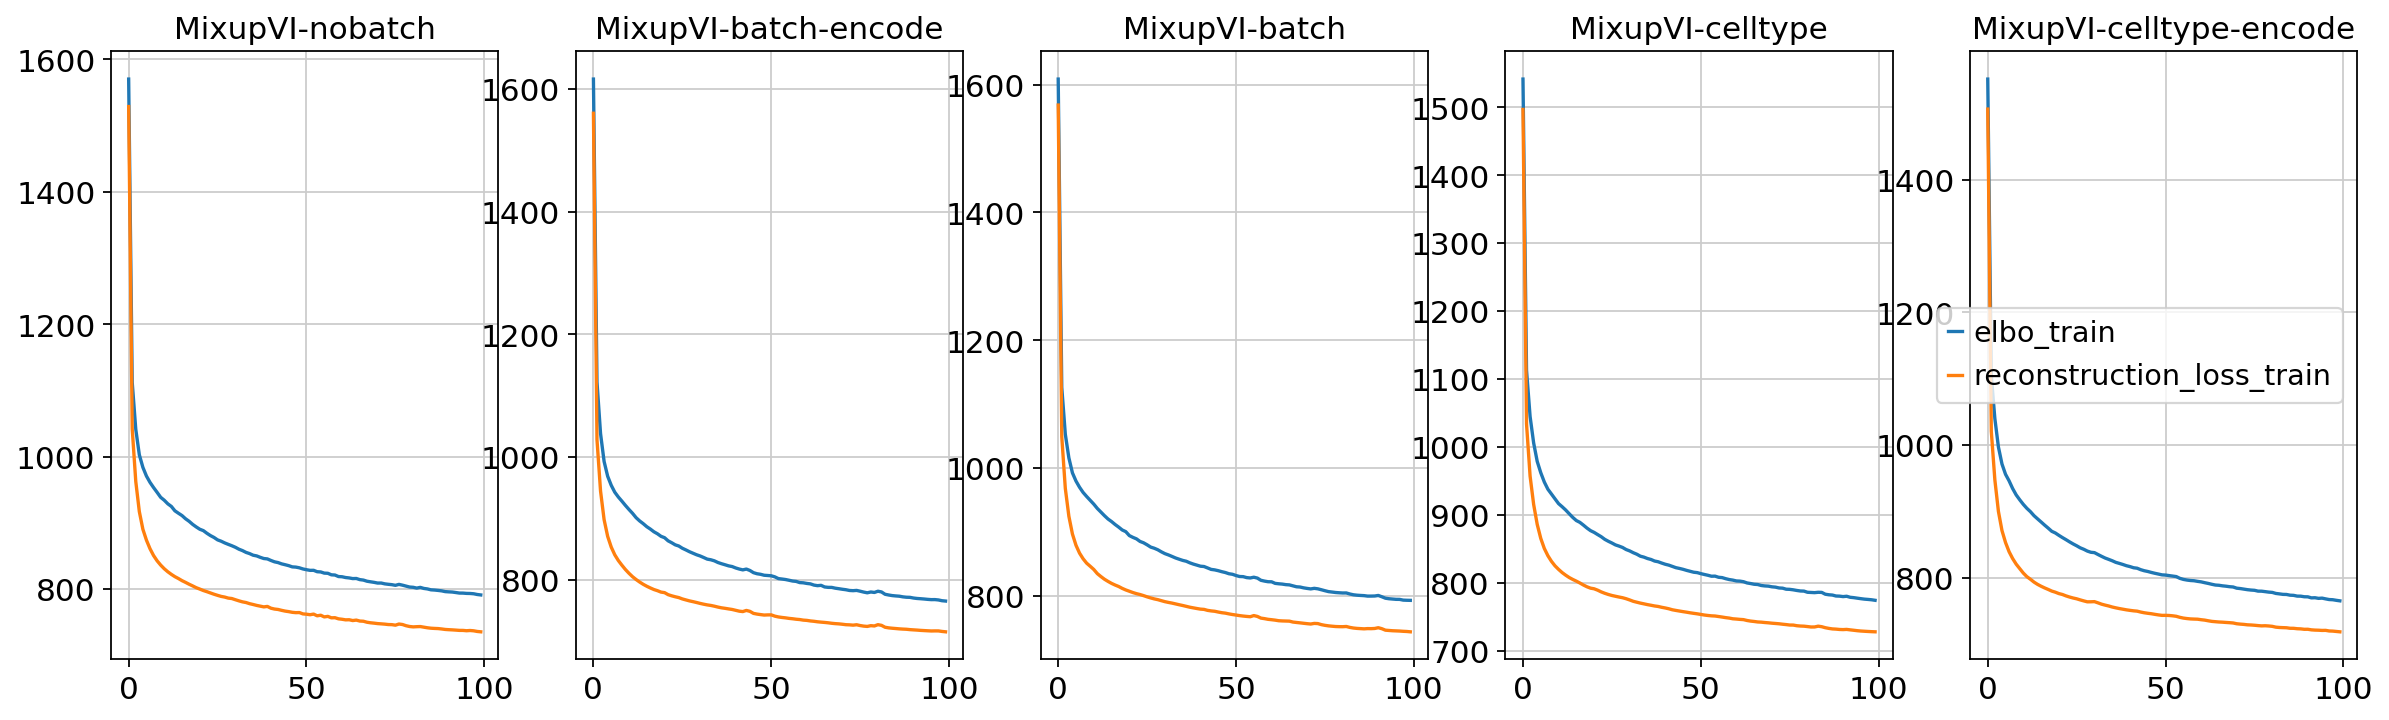

In [28]:
models = {
  "MixupVI-nobatch": model_1,
  "MixupVI-batch-encode": model_2,
  "MixupVI-batch": model_3,
  "MixupVI-celltype": model_4,
  "MixupVI-celltype-encode": model_5
}

fig, ax = plt.subplots(1, len(models), figsize=(18, 5))

for i, value in enumerate(models.items()):
  model_name, model = value
  ax[i].plot(model.history["elbo_train"], label="elbo_train")
  ax[i].plot(model.history["reconstruction_loss_train"], label="reconstruction_loss_train")
  ax[i].set_title(model_name)


plt.legend()

#### KL divergence

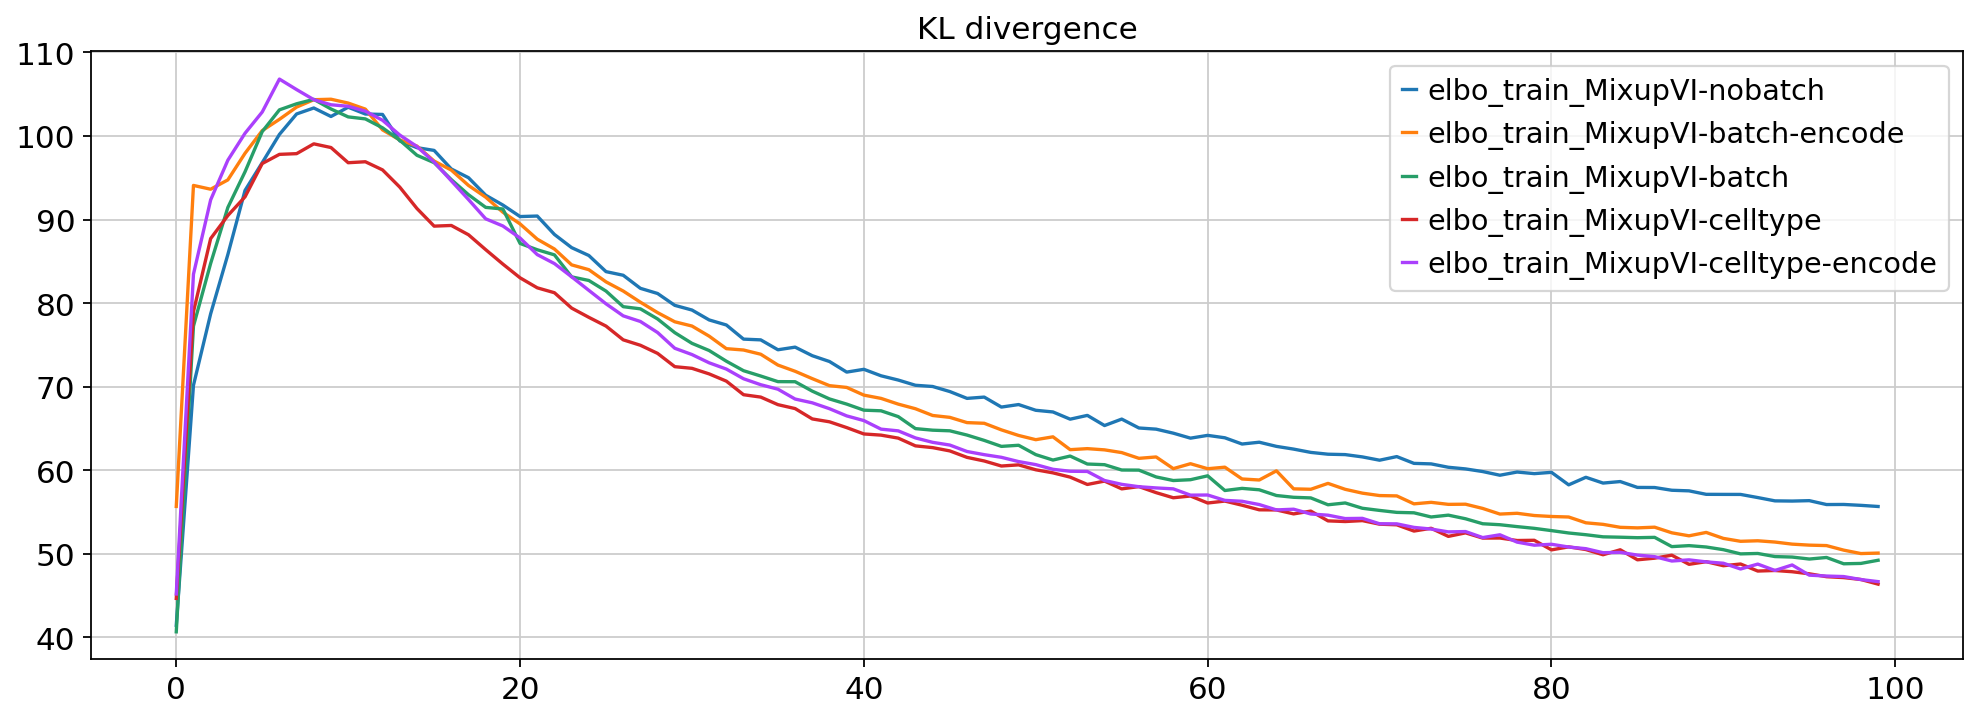

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

for i, value in enumerate(models.items()):
  model_name, model = value
  ax.plot(model.history["kl_local_train"], label=f"elbo_train_{model_name}")
  ax.set_title(model_name)


plt.legend()

plt.title("KL divergence")

plt.legend()

### Mixup loss, latent space and deconv metrics

#### Train

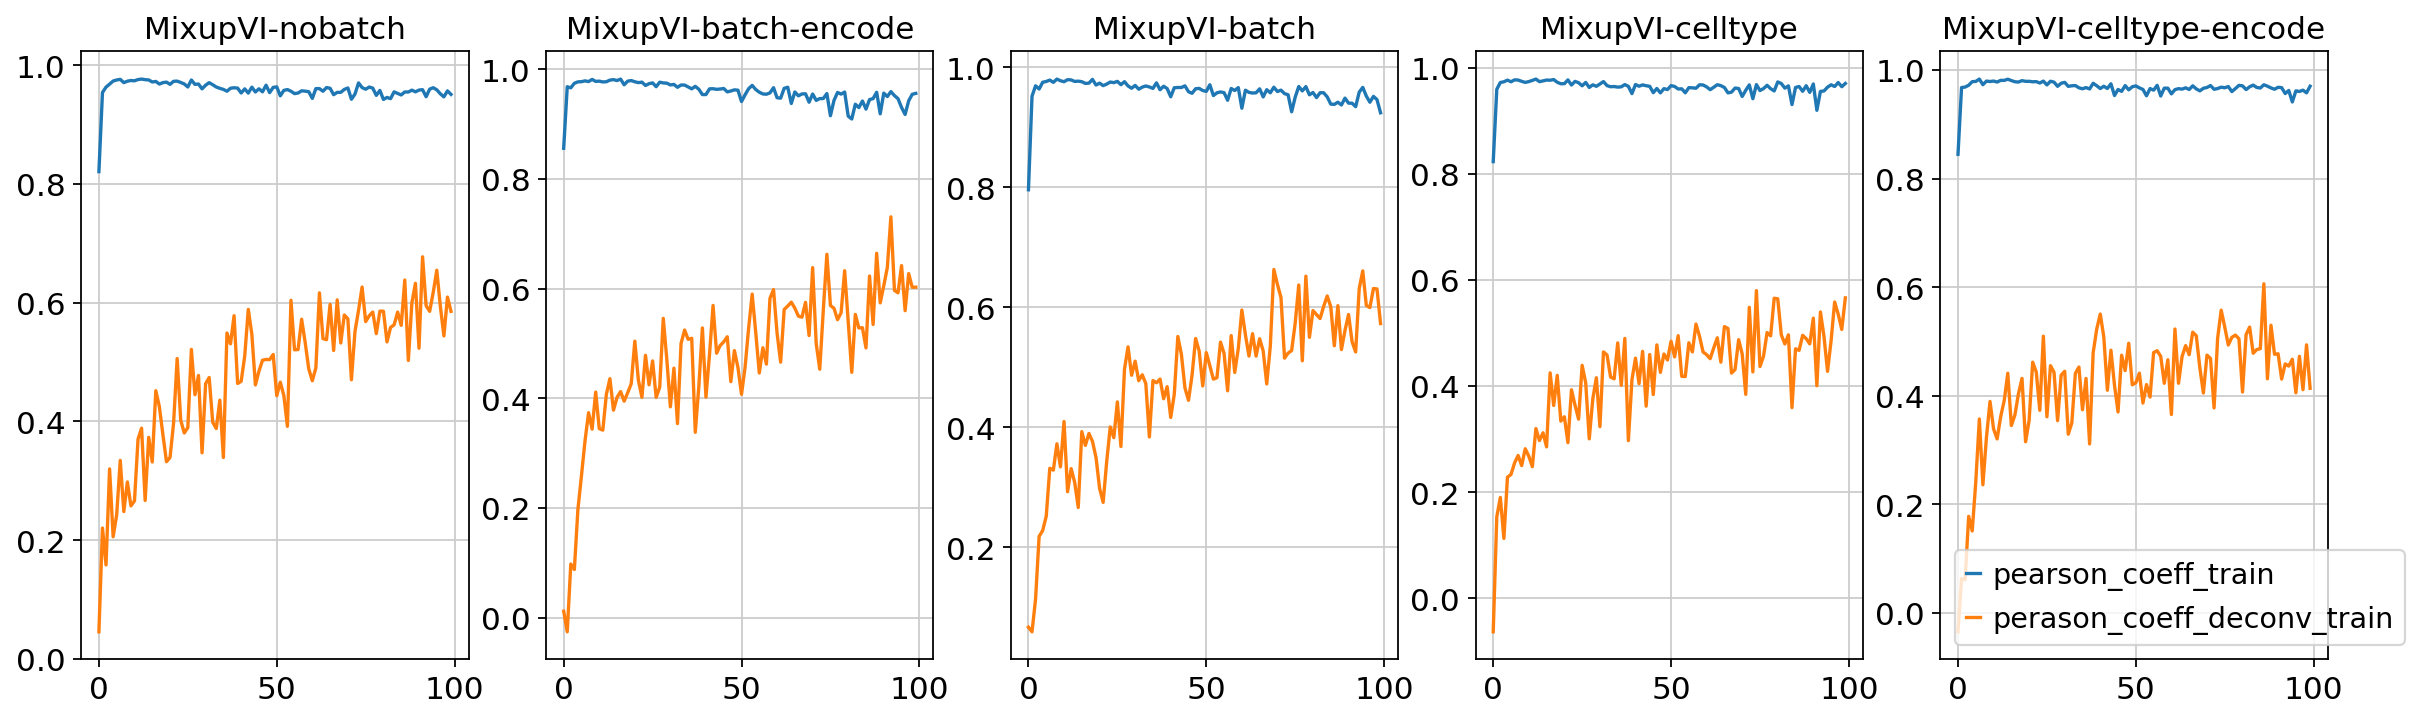

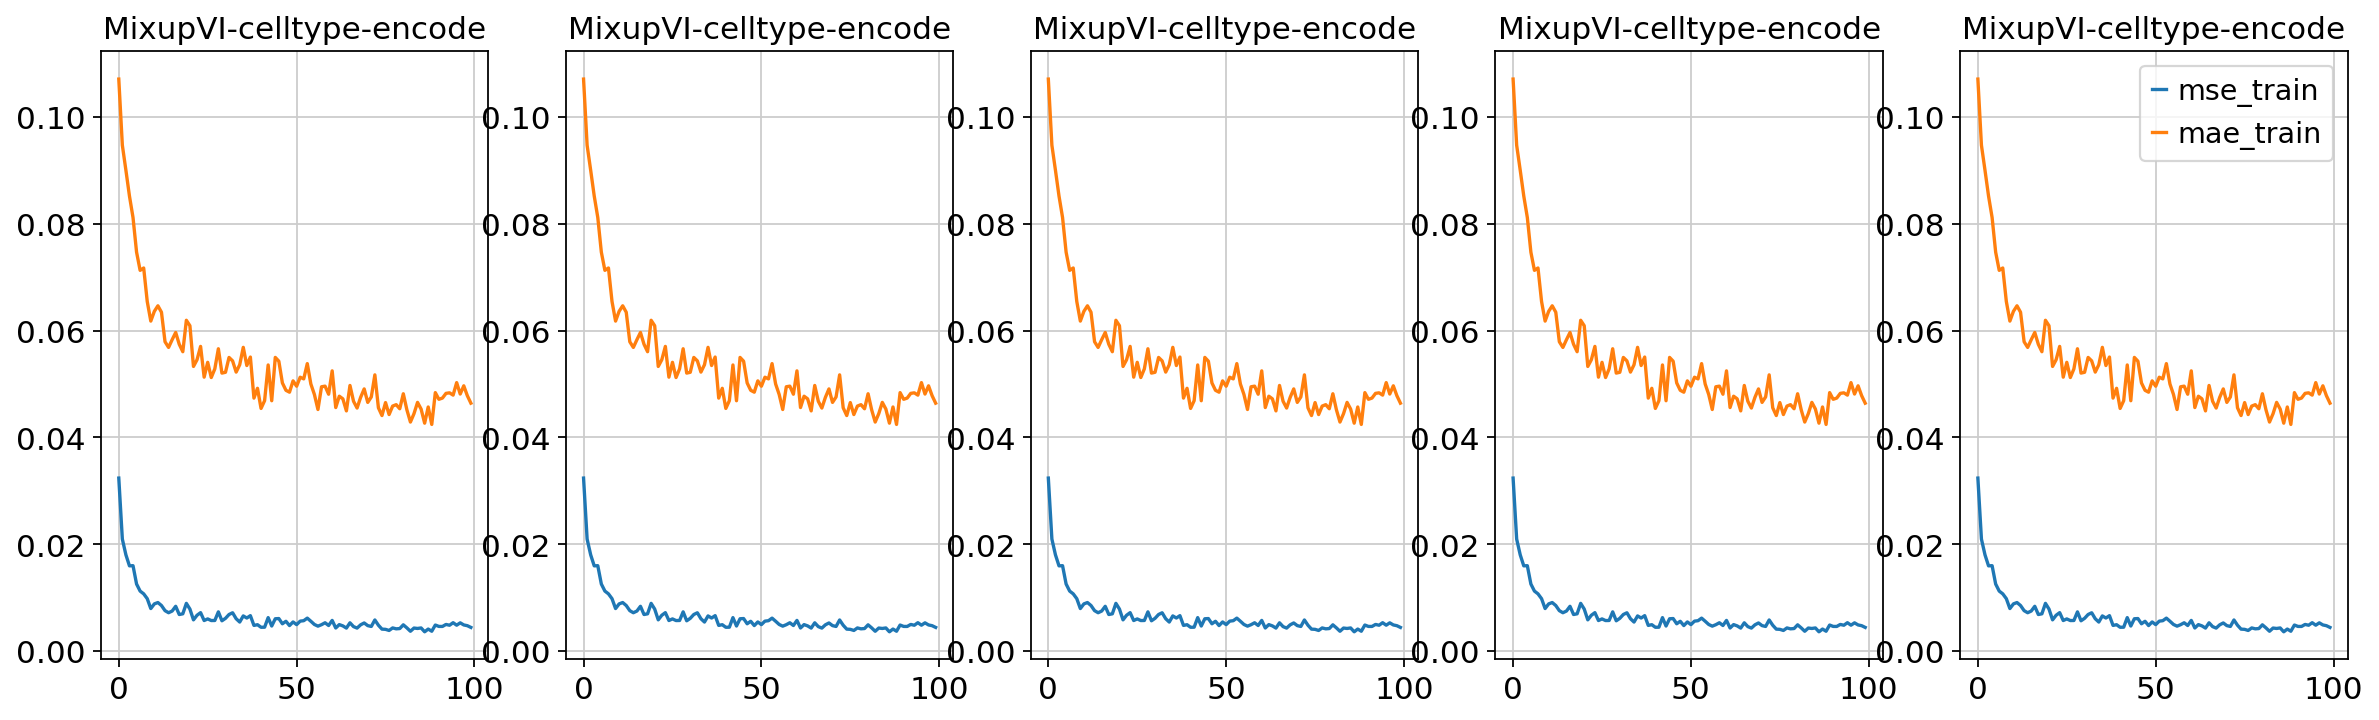

In [33]:
# correlation losses
fig, ax = plt.subplots(1, len(models), figsize=(18, 5))

for i, value in enumerate(models.items()):
  model_name, model = value
  ax[i].plot(model.history["pearson_coeff_train"], label="pearson_coeff_train")
  ax[i].plot(model.history["pearson_coeff_deconv_train"], label="perason_coeff_deconv_train")
  ax[i].set_title(model_name)
plt.legend()
# plt.title("MixupVI correlation losses")

# deconvolution losses
fig_2, ax_2 = plt.subplots(1, len(models), figsize=(18, 5))

for i, value in enumerate(models.items()):
  ax_2[i].plot(model.history["mse_deconv_train"], label="mse_train")
  ax_2[i].plot(model.history["mae_deconv_train"], label="mae_train")
  ax_2[i].set_title(model_name)
plt.legend()
# plt.title("MixupVI deconvolution losses")

#### Validation

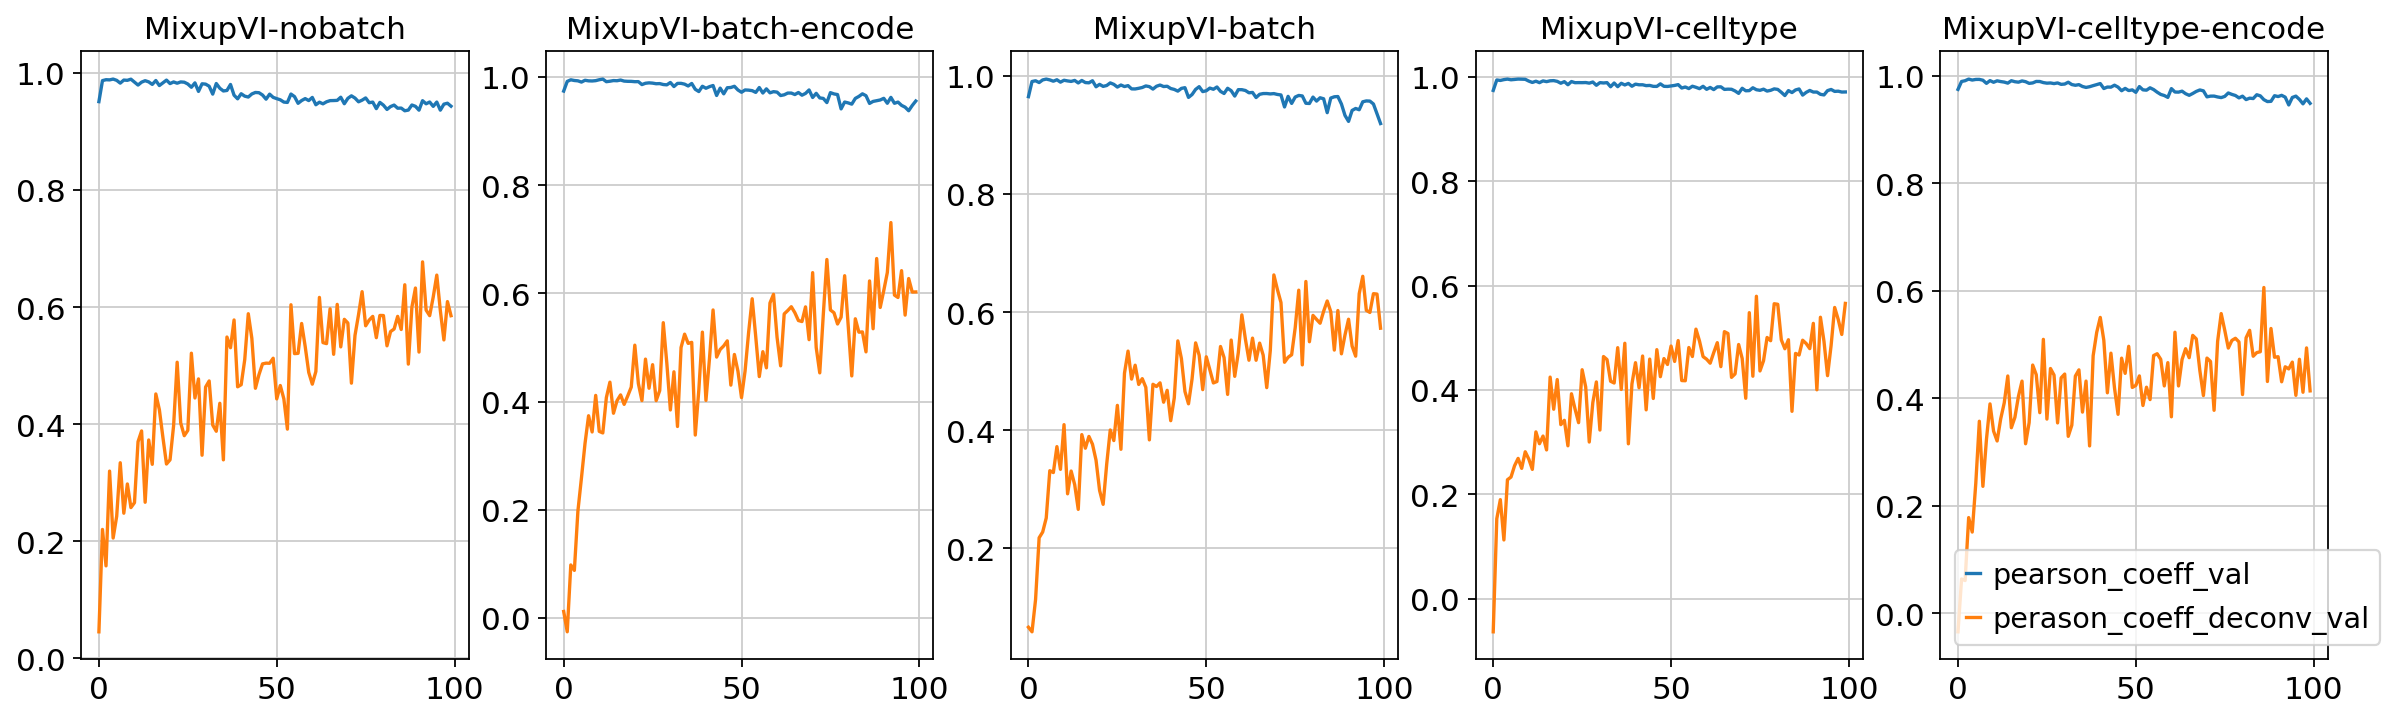

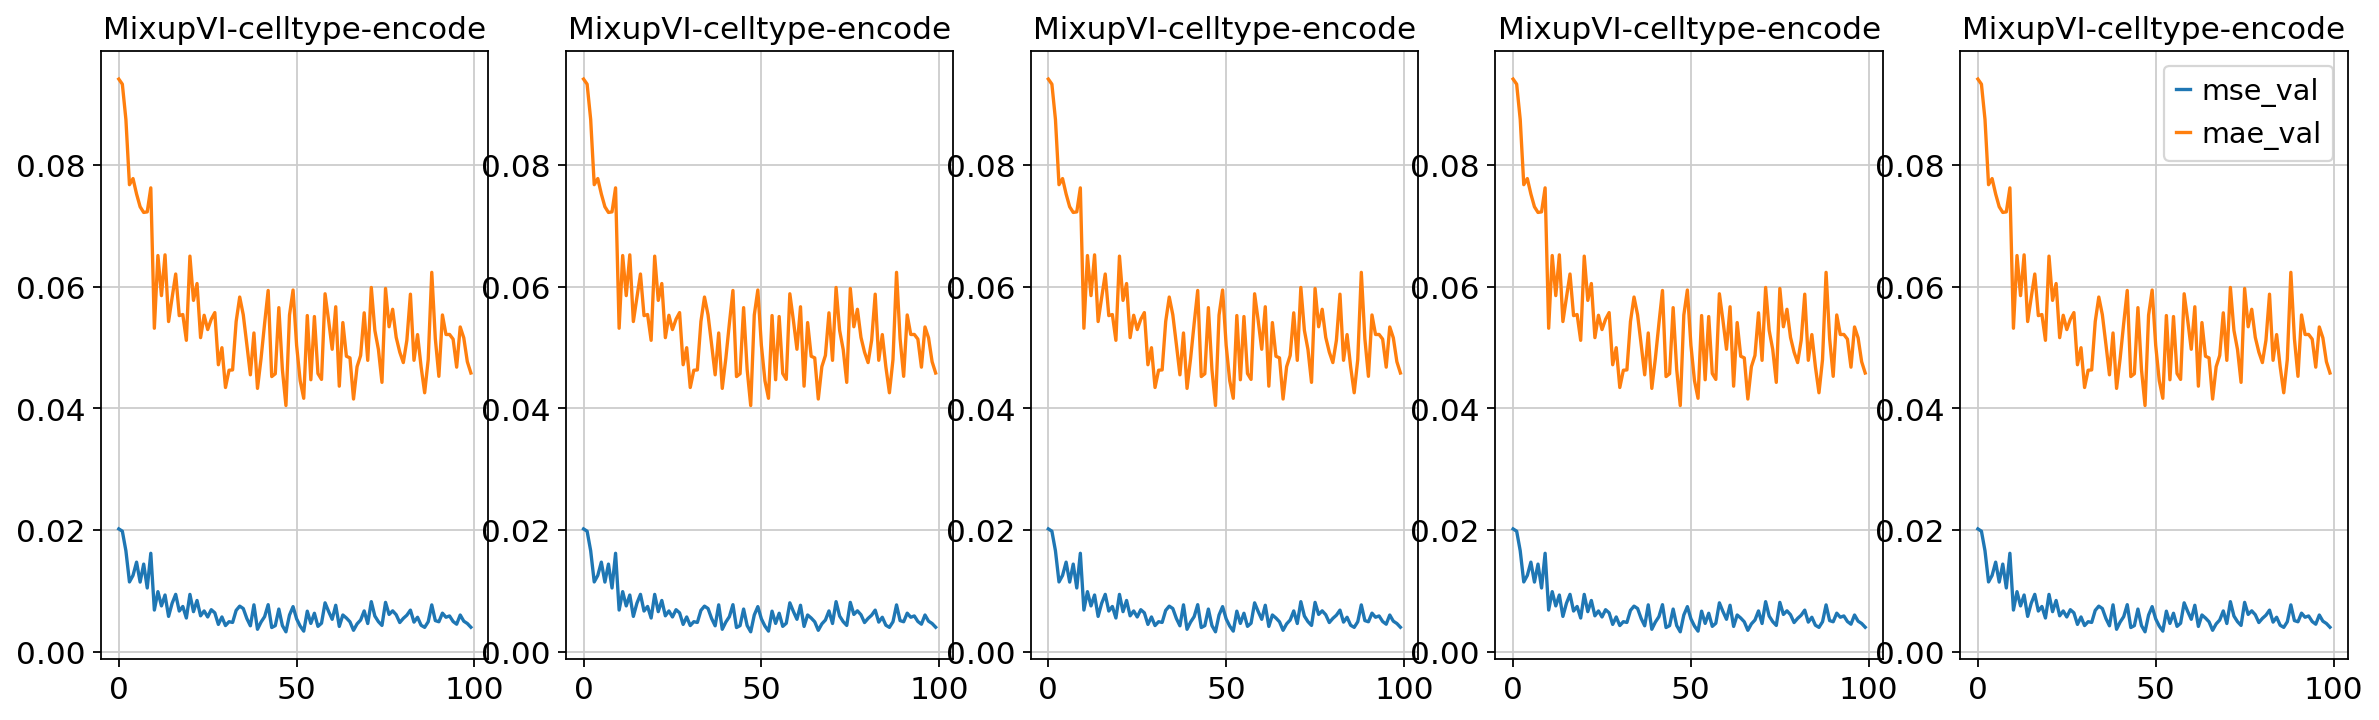

In [34]:
# Correlation losses
fig, ax = plt.subplots(1, len(models), figsize=(18, 5))

for i, value in enumerate(models.items()):
  model_name, model = value
  ax[i].plot(model.history["pearson_coeff_validation"], label="pearson_coeff_val")
  ax[i].plot(model.history["pearson_coeff_deconv_train"], label="perason_coeff_deconv_val")
  ax[i].set_title(model_name)
plt.legend()
# plt.title("MixupVI correlation losses")

# Deconvolution losses
fig_2, ax_2 = plt.subplots(1, len(models), figsize=(18, 5))

for i, value in enumerate(models.items()):
  ax_2[i].plot(model.history["mse_deconv_validation"], label="mse_val")
  ax_2[i].plot(model.history["mae_deconv_validation"], label="mae_val")
  ax_2[i].set_title(model_name)
plt.legend()
# plt.title("MixupVI deconvolution losses")

### Batch effects exploration

... storing 'cell_types_grouped' as categorical


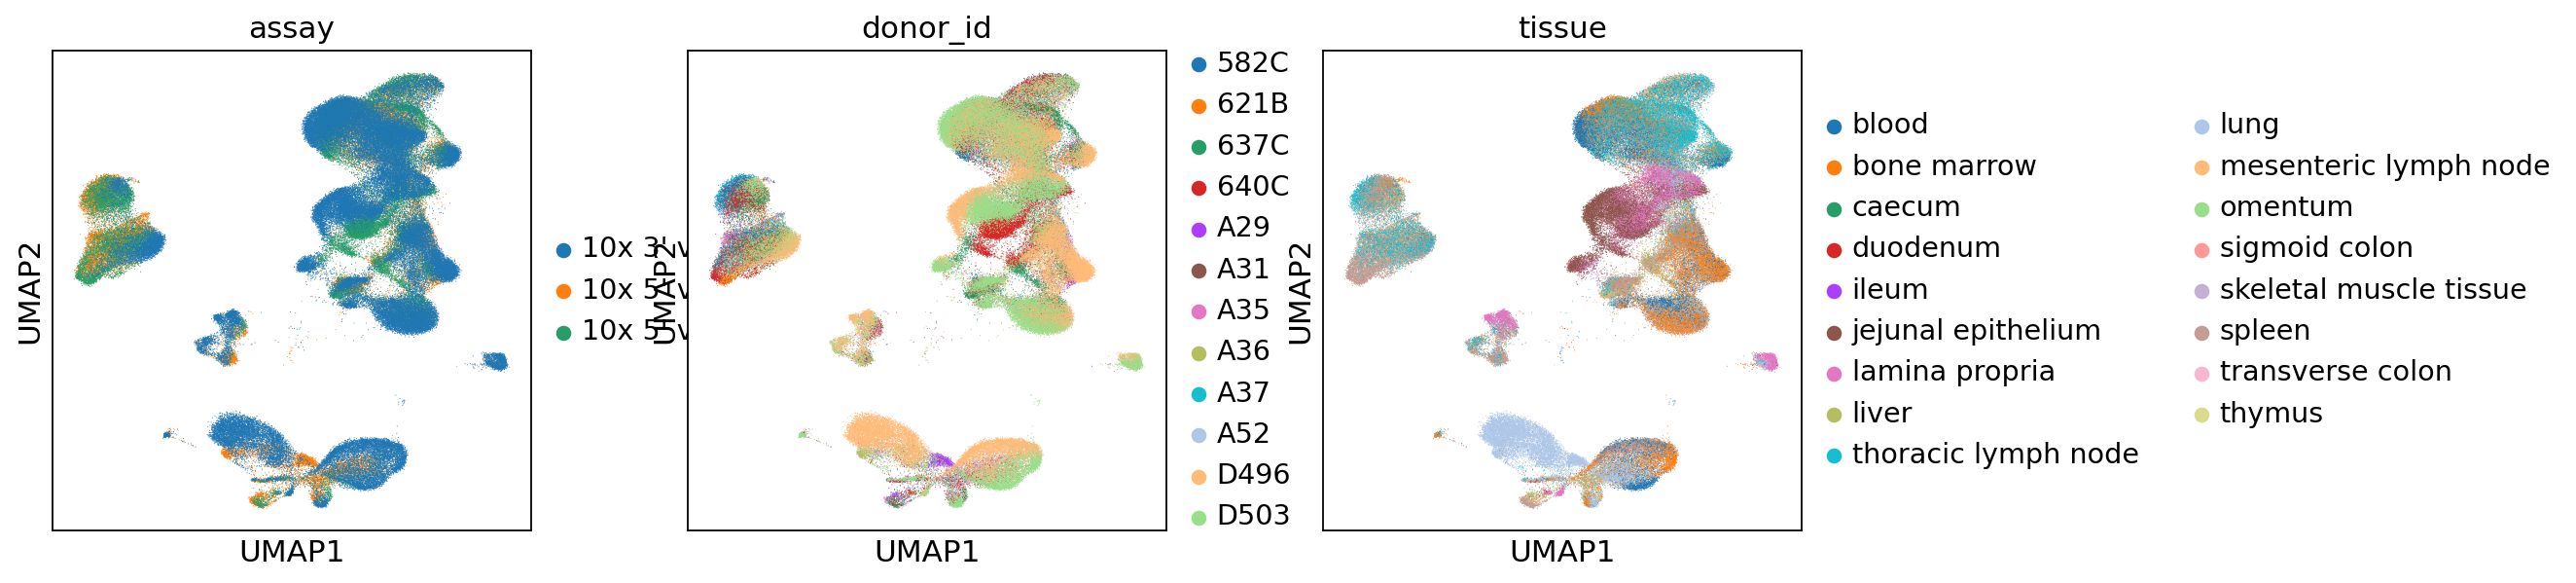

In [35]:
sc.pl.umap(adata_train,
          color=["assay", "donor_id", "tissue"]
          )

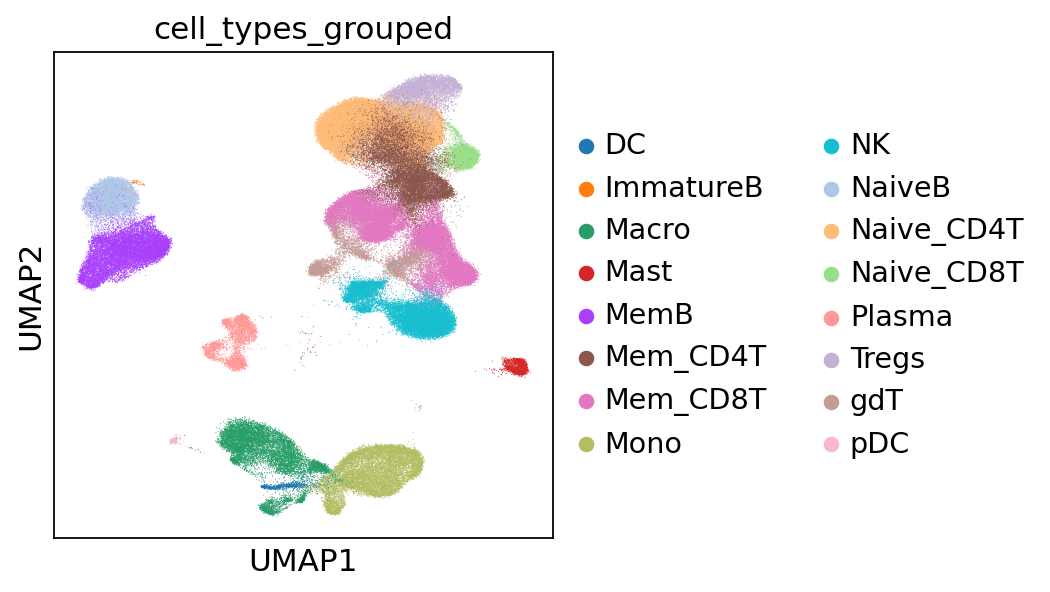

In [36]:
sc.pl.umap(adata_train,
          color=["cell_types_grouped"]
          )

### Latent space visualization

In [38]:
# all_adata_samples, adata_pseudobulk_counts, adata_pseudobulk_rc, groundtruth_fractions = create_dirichlet_pseudobulk_dataset(
#     adata_train, prior_alphas = None, n_sample = 2000,
# )

2024-03-01 17:18:18.294 | INFO     | benchmark_utils.dataset_utils:create_dirichlet_pseudobulk_dataset:250 - Creating dirichlet pseudobulk dataset...


In [41]:
# # MixupVI input
# adata_pseudobulk_mixupvi = ad.AnnData(X=adata_pseudobulk_train_counts.layers["counts"],
#                               obs=adata_pseudobulk_train_counts.obs,
#                               var=adata_pseudobulk_train_counts.var)

# adata_pseudobulk_mixupvi.layers["counts"] = adata_pseudobulk_mixupvi.X.copy()
# adata_pseudobulk_mixupvi.obs["cell_type"] = "mixed"
# adata_pseudobulk_mixupvi.obs["cell_types_grouped"] = "CD4T"

#### MixupVI-nobatch

In [50]:
# adata_full = ad.concat([adata_train, adata_pseudobulk_scvi]

adata_train.obsm["X_mixupVI"] = model_1.get_latent_representation(adata_train, get_pseudobulk=False)

In [51]:
# run PCA then generate UMAP plots
sc.pp.neighbors(adata_train,
                use_rep="X_mixupVI")
sc.tl.umap(adata_train, min_dist=0.3)

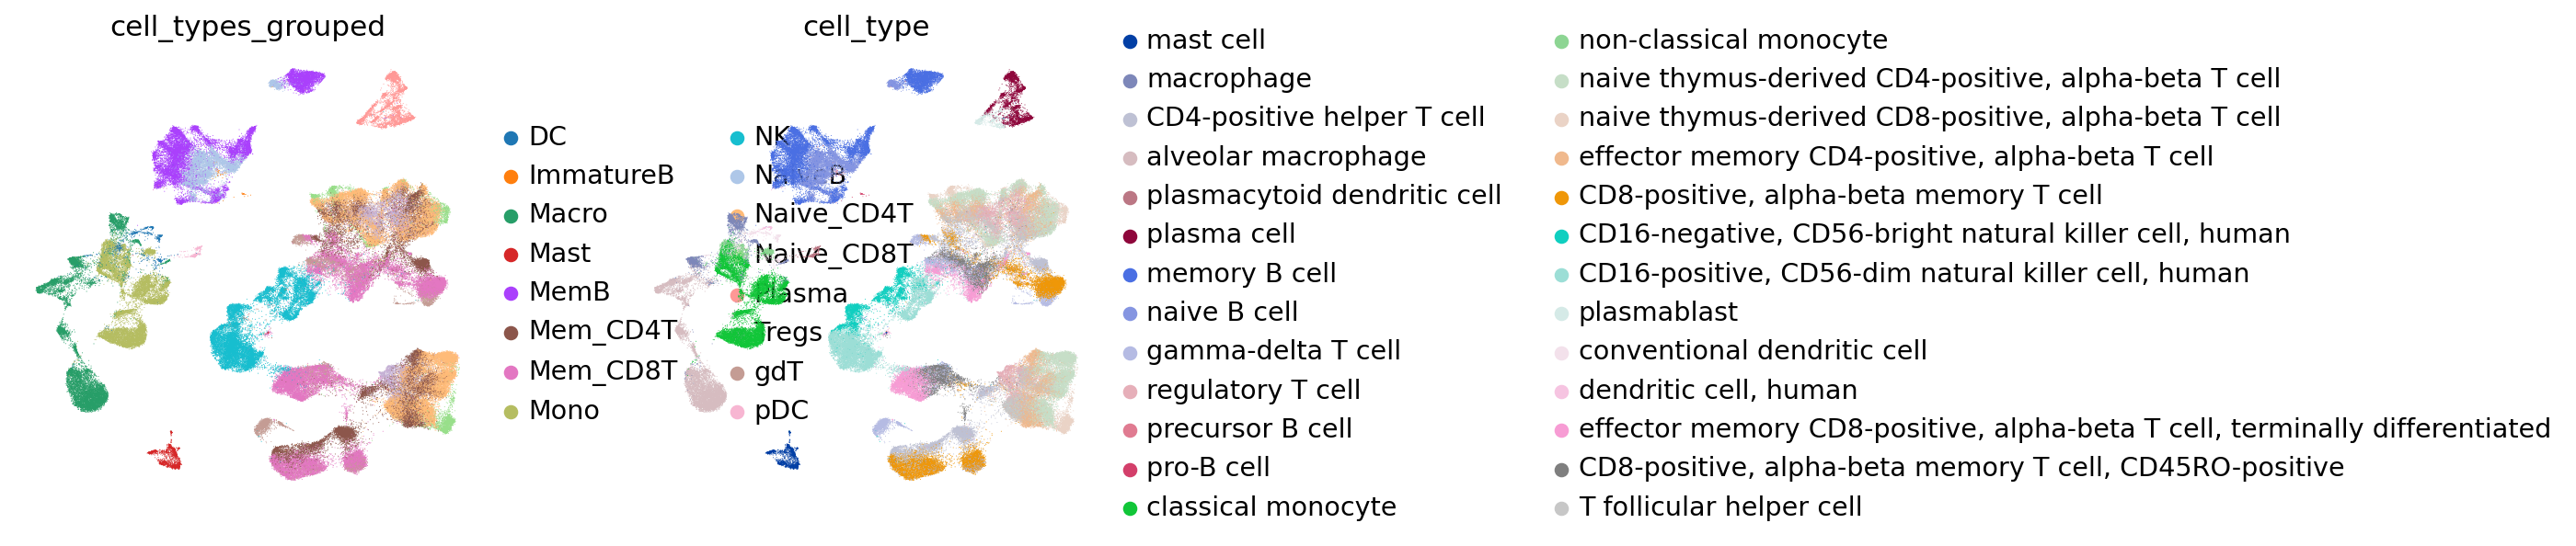

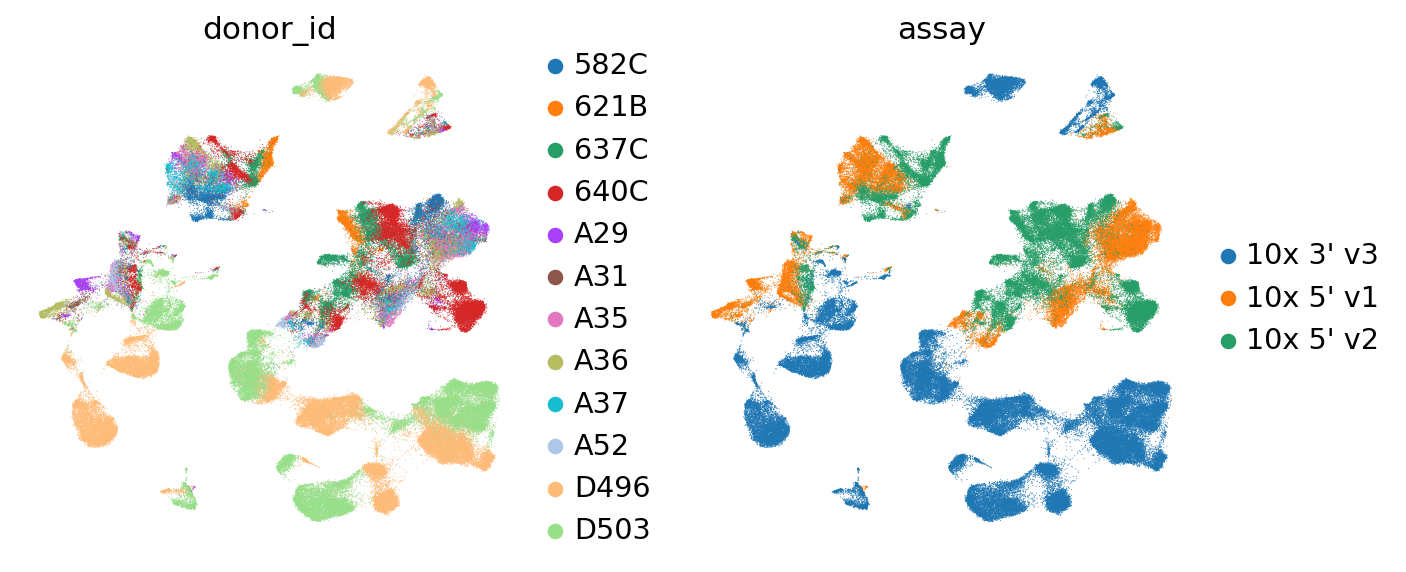

In [54]:
sc.pl.umap(
    adata_train,
    color=["cell_types_grouped", "cell_type"],
    frameon=False,
)
sc.pl.umap(
    adata_train,
    color=["donor_id", "assay"],
    ncols=2,
    frameon=False,
)

#### MixupVI batch-encode

In [55]:
# adata_full = ad.concat([adata_train, adata_pseudobulk_mixupvi]

adata_train.obsm["X_mixupVI_2"] = model_2.get_latent_representation(adata_train,
                                                                    get_pseudobulk=False)

In [56]:
# run PCA then generate UMAP plots
sc.pp.neighbors(adata_train,
                use_rep="X_mixupVI_2")
sc.tl.umap(adata_train, min_dist=0.3)

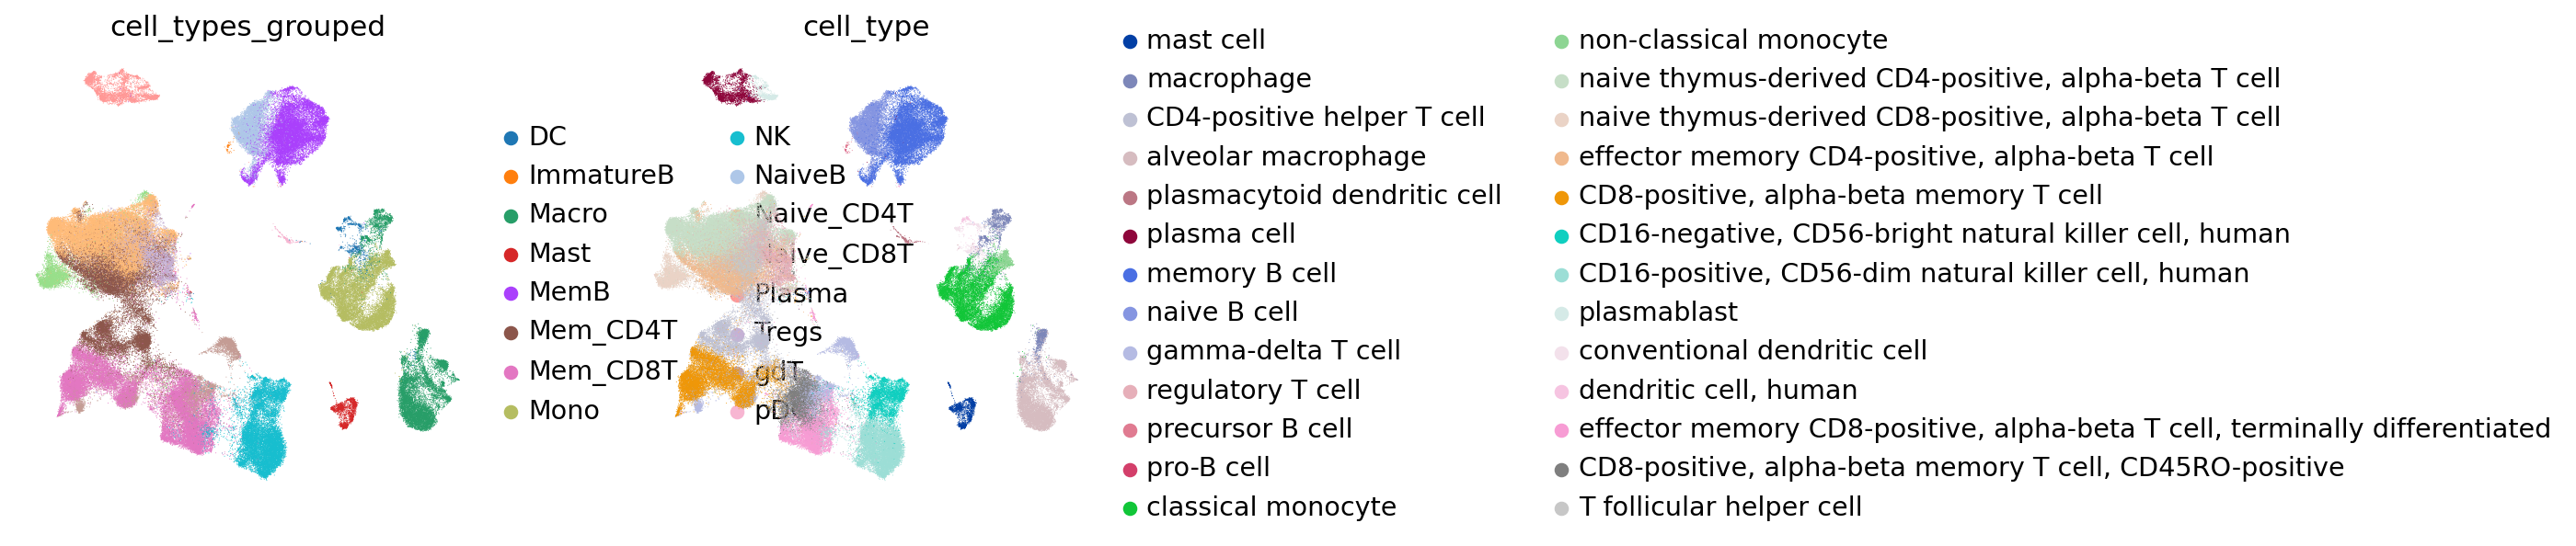

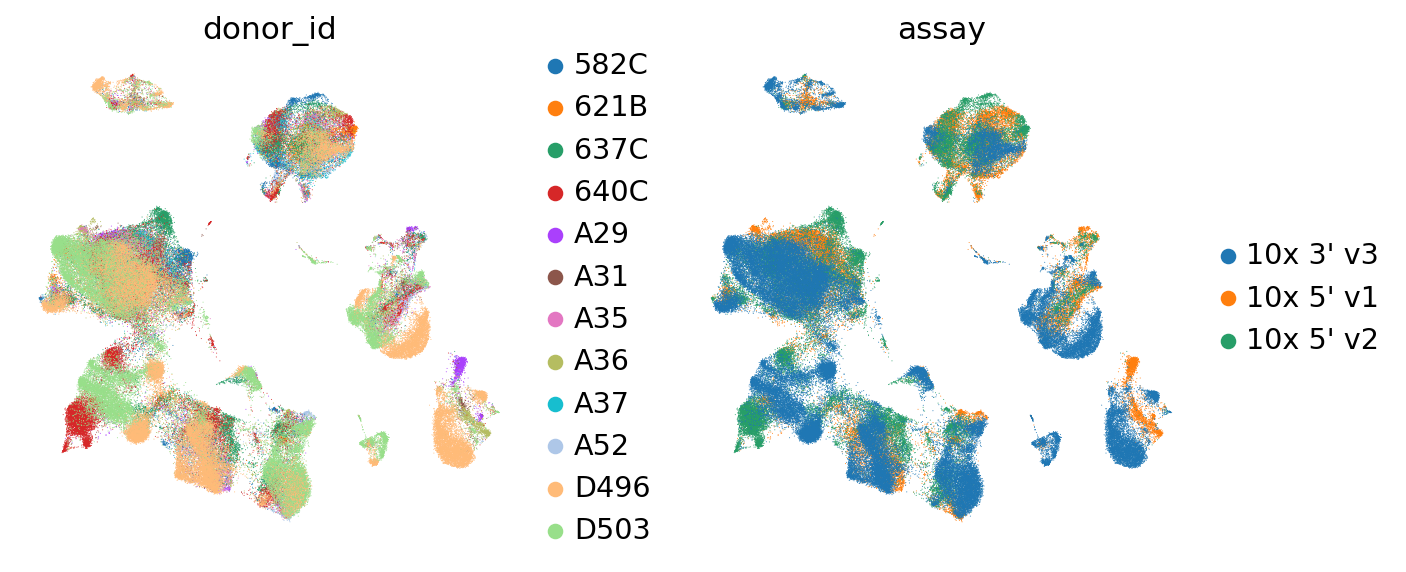

In [58]:
sc.pl.umap(
    adata_train,
    color=["cell_types_grouped", "cell_type"],
    frameon=False,
)
sc.pl.umap(
    adata_train,
    color=["donor_id", "assay"],
    ncols=2,
    frameon=False,
)

#### MixupVI-batch

In [59]:
models

SCVI Model with the following params: 
n_hidden: 128, n_latent: 30, n_layers: 1, dropout_rate: 0.1, dispersion: gene, gene_likelihood: zinb, 
latent_distribution: normal
Training status: Trained
Model's adata is minified?: False

SCVI Model with the following params: 
n_hidden: 128, n_latent: 30, n_layers: 1, dropout_rate: 0.1, dispersion: gene, gene_likelihood: zinb, 
latent_distribution: normal
Training status: Trained
Model's adata is minified?: False

SCVI Model with the following params: 
n_hidden: 128, n_latent: 30, n_layers: 1, dropout_rate: 0.1, dispersion: gene, gene_likelihood: zinb, 
latent_distribution: normal
Training status: Trained
Model's adata is minified?: False

SCVI Model with the following params: 
n_hidden: 128, n_latent: 30, n_layers: 1, dropout_rate: 0.1, dispersion: gene, gene_likelihood: zinb, 
latent_distribution: normal
Training status: Trained
Model's adata is minified?: False

SCVI Model with the following params: 
n_hidden: 128, n_latent: 30, n_layers: 1, dropout_rate: 0.1, dispersion: gene, gene_likelihood: zinb, 
latent_distribution: normal
Training status: Trained
Model's adata is minified?: False

{'MixupVI-nobatch': ,
 'MixupVI-batch-encode': ,
 'MixupVI-batch': ,
 'MixupVI-celltype': ,
 'MixupVI-celltype-encode': }

In [88]:
# adata_train = ad.concat([adata_train, adata_pseudobulk_condscvi]
#                        )
adata_full.obsm["X_mixupVI_3"] = model_3.get_latent_representation(adata_train, get_pseudobulk=False)

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


In [90]:
# run PCA then generate UMAP plots
sc.pp.neighbors(adata_full,
                use_rep="X_condscvi")
sc.tl.umap(adata_full, min_dist=0.3)

... storing 'donor_id' as categorical
... storing 'Predicted_labels_CellTypist' as categorical


... storing 'Majority_voting_CellTypist' as categorical
... storing 'Majority_voting_CellTypist_high' as categorical
... storing 'Manually_curated_celltype' as categorical
... storing 'assay_ontology_term_id' as categorical
... storing 'cell_type_ontology_term_id' as categorical
... storing 'development_stage_ontology_term_id' as categorical
... storing 'disease_ontology_term_id' as categorical
... storing 'self_reported_ethnicity_ontology_term_id' as categorical
... storing 'organism_ontology_term_id' as categorical
... storing 'sex_ontology_term_id' as categorical
... storing 'tissue_ontology_term_id' as categorical
... storing 'suspension_type' as categorical
... storing 'cell_type' as categorical
... storing 'assay' as categorical
... storing 'disease' as categorical
... storing 'organism' as categorical
... storing 'sex' as categorical
... storing 'tissue' as categorical
... storing 'self_reported_ethnicity' as categorical
... storing 'development_stage' as categorical
... storing

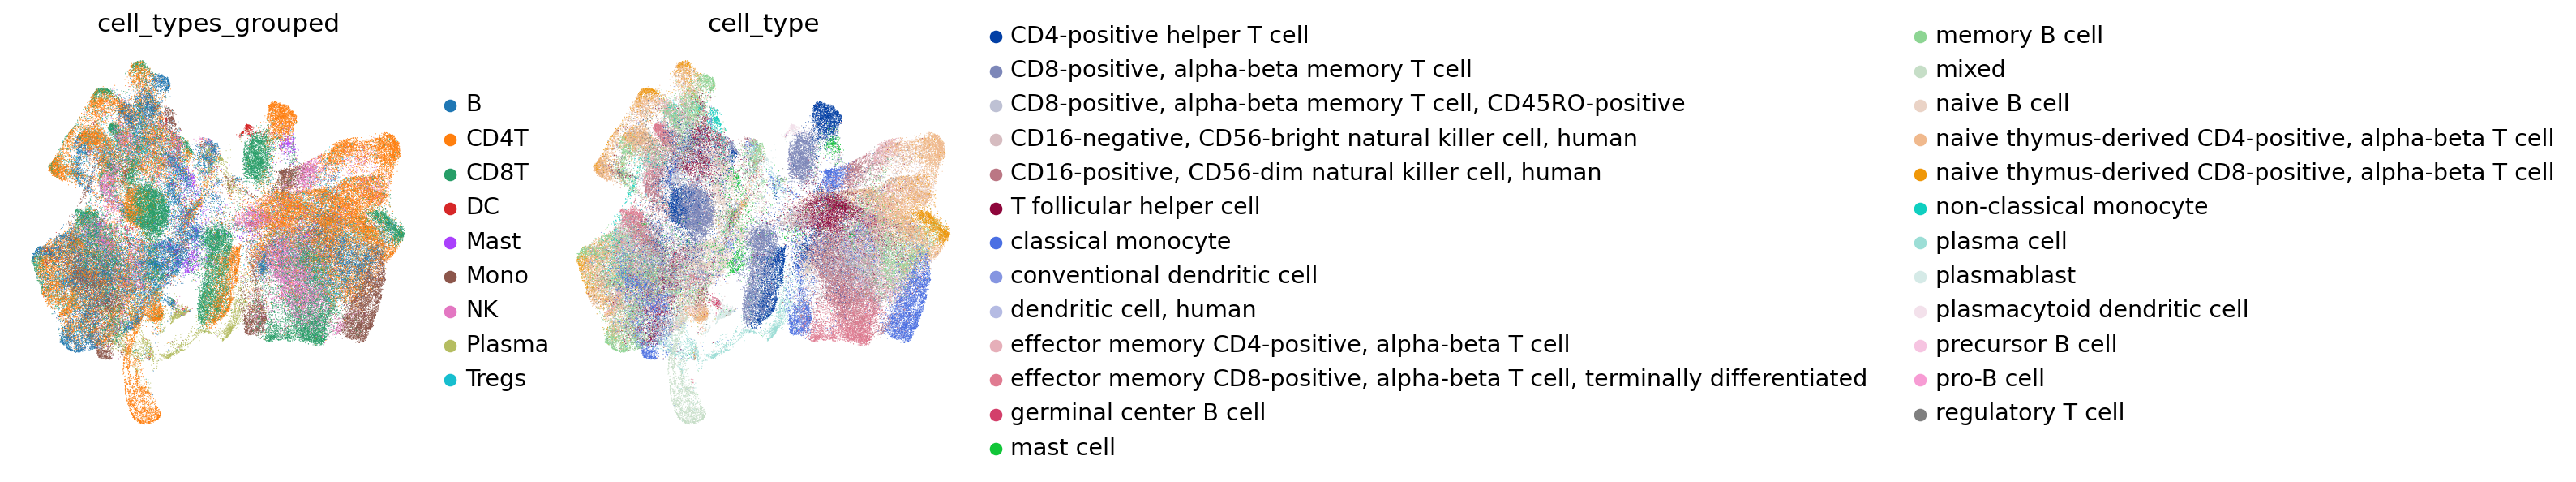

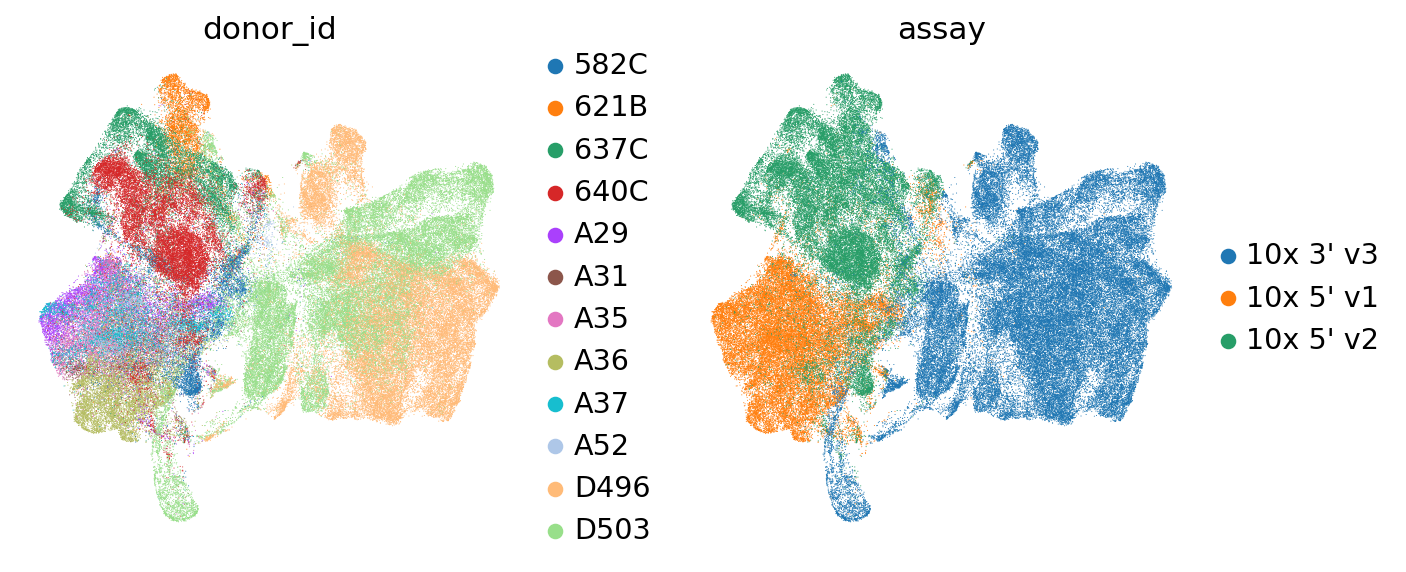

In [92]:
sc.pl.umap(
    adata_full,
    color=["cell_types_grouped", "cell_type"],
    frameon=False,
)
sc.pl.umap(
    adata_full,
    color=["donor_id", "assay"],
    ncols=2,
    frameon=False,
)

Deconvolution

In [96]:
generative_models = {
    "scVI": scvi_model,
    "MixUpVI": mixupvi_model,
}

In [94]:
adata_pseudobulk_test_counts, _, df_proportions_test = create_dirichlet_pseudobulk_dataset(
        adata_test,
        prior_alphas = None,
        n_sample = 400,
        n_cells = 1000,
        add_sparsity=True
    )

2024-01-22 15:34:22.703 | INFO     | benchmark_utils.dataset_utils:create_dirichlet_pseudobulk_dataset:215 - Creating dirichlet pseudobulk dataset...


In [98]:
signature, intersection = create_signature(
    adata,
    signature_type=SIGNATURE_CHOICE,
)

In [125]:
model = "MixUpVI"

if model == "NNLS":
    deconv_results = perform_nnls(signature,
                                _[:, intersection])
else:
    adata_latent_signature = create_latent_signature(
        adata=adata_train,
        model=generative_models[model],
        average_all_cells = True,
        sc_per_pseudobulk=1000,
    )
    deconv_results = perform_latent_deconv(
        adata_pseudobulk=adata_pseudobulk_test_counts,
        adata_latent_signature=adata_latent_signature,
        model=generative_models[model],
    )

deconv_results

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer

CD4T      CD8T         B    Plasma        DC        NK  \
sample_0    0.079033  0.008060  0.073435  0.221547  0.047563  0.104633   
sample_1    0.161207  0.185044  0.076921  0.045572  0.050548  0.138705   
sample_2    0.003631  0.288814  0.082908  0.050687  0.197205  0.029606   
sample_3    0.065194  0.286762  0.040697  0.169694  0.020611  0.161772   
sample_4    0.138243  0.176020  0.067358  0.082856  0.014557  0.006453   
...              ...       ...       ...       ...       ...       ...   
sample_395  0.148315  0.091745  0.074712  0.156167  0.070477  0.121546   
sample_396  0.074241  0.133977  0.018168  0.167640  0.211773  0.150749   
sample_397  0.102627  0.197483  0.041872  0.147779  0.055036  0.128522   
sample_398  0.058089  0.265076  0.048232  0.187122  0.100593  0.039209   
sample_399  0.096611  0.089064  0.082840  0.185260  0.061900  0.114653   

                Mono      Mast     Tregs  
sample_0    0.237867  0.022189  0.205672  
sample_1    0.110213  0.120426  0.111365  
sample_2    0.028718  0.275335  0.043097  
sample_3    0.136243  0.106394  0.012633  
sample_4    0.307099  0.013734  0.193679  
...              ...       ...       ...  
sample_395  0.225784  0.066337  0.044918  
sample_396  0.079198  0.069939  0.094316  
sample_397  0.167746  0.077880  0.081055  
sample_398  0.137096  0.103173  0.061410  
sample_399  0.125535  0.093076  0.151061  

[400 rows x 9 columns]

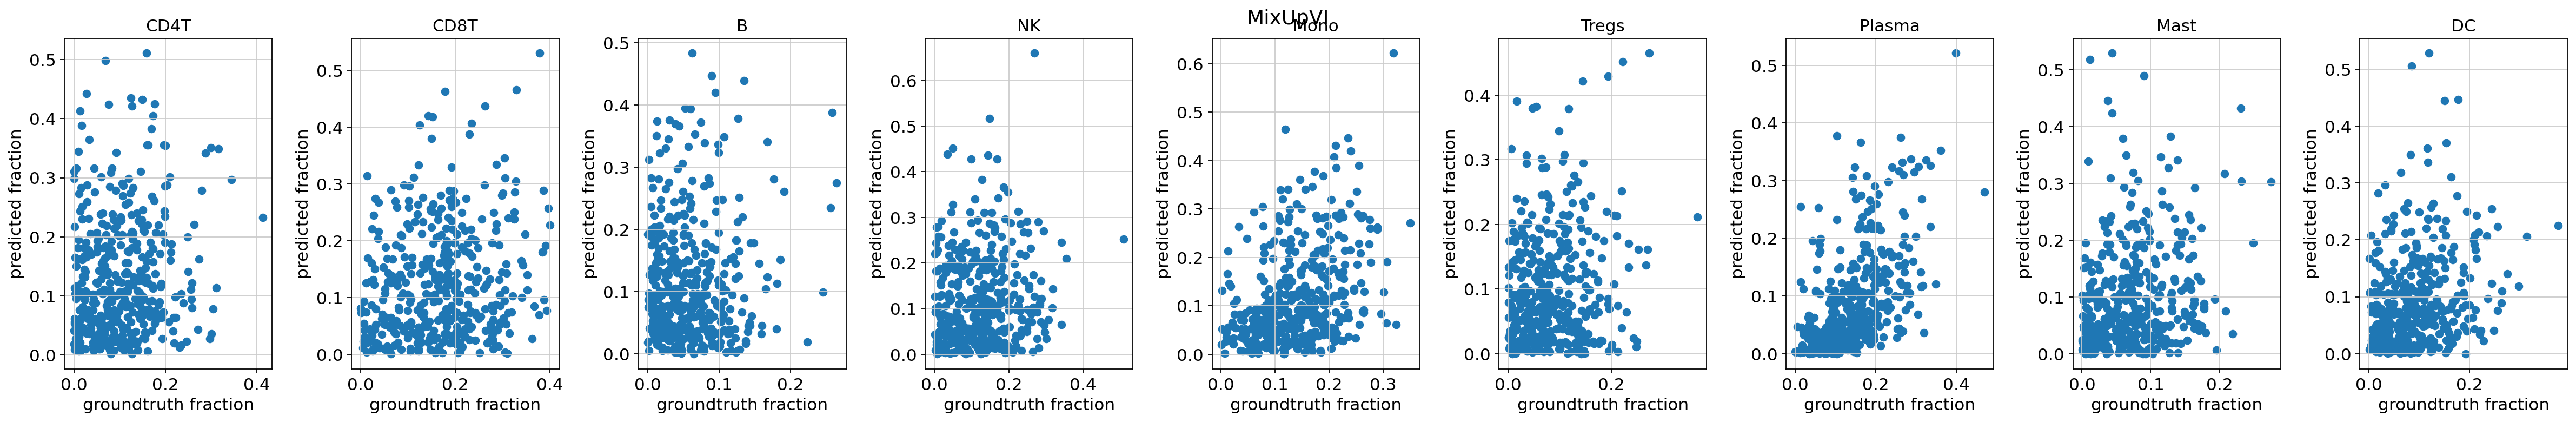

In [126]:
# Get the column names from both DataFrames
columns_df1 = df_proportions_test.columns
columns_df2 = deconv_results.columns

# Check if the columns are the same in both DataFrames
if not set(columns_df1) == set(columns_df2):
    raise ValueError("Column names are not the same in both DataFrames")

# Create a subplot grid
num_columns = len(columns_df1)
fig, axes = plt.subplots(nrows=1, ncols=num_columns, figsize=(30, 5))  # Adjust the figsize as needed

# Iterate over each column and create a scatterplot
for i, column in enumerate(columns_df1):
    ax = axes[i] if num_columns > 1 else axes  # Use the appropriate axis for single-column case
    ax.scatter(deconv_results[column], df_proportions_test[column])
    ax.set_title(column)
    ax.set_xlabel(f'groundtruth fraction')
    ax.set_ylabel(f'predicted fraction')

# Adjust layout for better spacing
plt.tight_layout()
plt.suptitle(model)

# Show the plot
plt.show()